# 3. 분류

## 3.1 MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/Users/naru/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.   0.   0.   0.
   0. 

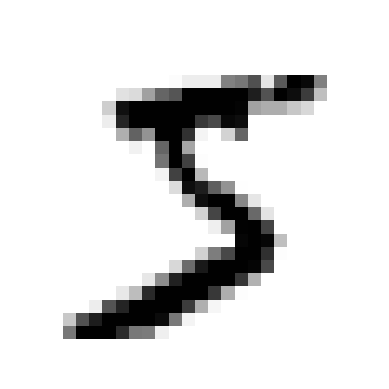

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
print(some_digit)

some_digit_image = some_digit.reshape(28,28)
print(some_digit_image)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[0] #실제 레이블 확인 

'5'

In [7]:
import numpy as np

y = y.astype(np.uint8)

In [8]:
# train, test 분리

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련

* mnist dataset은 0~9까지 숫자가 있다
* 이번 파트에서는 숫자 5만 식별한는 분류기 생성

In [15]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
# SGDClassifier 이용

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=2023)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=2023)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

In [20]:
# train set만을 이요한 검정

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for tr_idx, ts_idx in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) #clone을 안해줘도 된다. 왜하는지 모르겠음
    
    X_train_folds = X_train[tr_idx]
    y_train_folds = y_train_5[tr_idx]
    
    X_test_fold = X_train[ts_idx] 
    y_test_fold = y_train_5[ts_idx] 
    
    clone_clf.fit(X_train_folds, y_train_folds) 
    y_pred = clone_clf.predict(X_test_fold) 
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9659
0.96755
0.9598


In [21]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring='accuracy')

array([0.9587 , 0.9572 , 0.96035])

In [22]:
#모든 예측을 0(False)로하는 더미 분류기

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [23]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring='accuracy')

# 정확도를 성능지표로 사용하지 않는이유
# 불균형 데이터의경우 특히 심하게 불균형일경우 한 label로 찍어도 정확도가 높게 나온다

array([0.91125, 0.90855, 0.90915])

### 3.3.2 오차행렬

$confusion\_matrix = 
\begin{pmatrix}
    TN , FP \\
    FN , TP \\
\end{pmatrix}$

In [24]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [26]:
y_train_pred #모든 train_set에 대한 predict값이 출력된다

60000

In [32]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_train_5, y_train_pred) #행은 첫번째 인자 열은 두번째 인자로 계산됨 -> 행은 실제값 열은 예측값으로 만들어짐
mat

array([[53205,  1374],
       [ 1101,  4320]])

### 3.3.3 정밀도와 재현율

$precision(정밀도) = \dfrac{TP}{TP+FP}$ 
* 예측 양성중 정확하게 맞춘 비율 
* 민감도라고도 부른다(sensitivity)

$recall(재현율) = \dfrac{TP}{TP+FN}$
* 실제 양성중 정확하게 맞춘 비율

In [35]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))


0.7586933614330874
0.7969009407858328


F1 점수

$ F_{1}score = \dfrac{2}{\dfrac{1}{precision} + \dfrac{1}{recall}} = 2 * \dfrac{precision * recall}{precision+recall}$

* 정밀도와 재현율의 조화평균

In [36]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.777327935222672

### 3.3.4 정밀도/재현율 트레이드오프

보통 임계값을 올리면 정밀도가 높아지고 재현율은 떨어진다, 반대도 성립

In [37]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([5216.90232564])

In [38]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

#threshold 가 0일때 y_scores가 5216임으로 True로 예측

array([ True])

In [39]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [64]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

# method를 주지않았을때는 결과로 예측값이 나온다
# method를 decision_function으로 주면 결과로 예측 점수가 나온다

In [41]:
y_scores

array([ 10039.29544457, -16735.6013513 , -32307.88690651, ...,
        12201.58775094,  -6858.53784519,  -9365.72501489])

precision_recall_curve

* probability(scores) >= Threshold : positive pred
* probability(scores) < Threshold : negative pred

In [42]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [47]:
print(len(precisions))
print(len(recalls))
print(len(thresholds))

60001
60001
60000


In [57]:
import pandas as pd

pd.Series(y_train_5).value_counts()

False    54579
True      5421
dtype: int64

In [62]:
y_train_5[-10:]

array([False, False, False,  True, False, False, False,  True, False,
       False])

In [90]:
precisions

array([0.09035   , 0.09035151, 0.09035301, ..., 1.        , 1.        ,
       1.        ])

In [83]:
recalls[-10:]

array([0.00129127, 0.00110681, 0.00110681, 0.00092234, 0.00092234,
       0.00073787, 0.0005534 , 0.00036894, 0.00018447, 0.        ])

In [82]:
thresholds[-10:]

array([28864.52054013, 28935.43441864, 30906.32623067, 30943.87129309,
       31108.49865943, 31217.67910317, 32244.35072319, 33079.17015239,
       36668.30256183, 38483.42175818])

In [87]:
test_df = pd.DataFrame({'label' : y_train_5,
                        'asc_score' : y_scores})
                       
test_df.sort_values('asc_score').tail(10)

,label,asc_score
15830,True,28864.520540
12638,True,28935.434419
46435,False,30906.326231
19529,True,30943.871293
42665,False,31108.498659
53497,True,31217.679103
18553,True,32244.350723
19449,True,33079.170152
55161,True,36668.302562
47320,True,38483.421758


In [81]:
test_df.tail(10)

,label,score
59990,False,-20587.171950
59991,False,-14231.882395
59992,False,-5300.332792
59993,True,7231.750610
59994,False,-2568.638695
59995,False,-10658.708092
59996,False,-19047.006591
59997,True,12201.587751
59998,False,-6858.537845
59999,False,-9365.725015


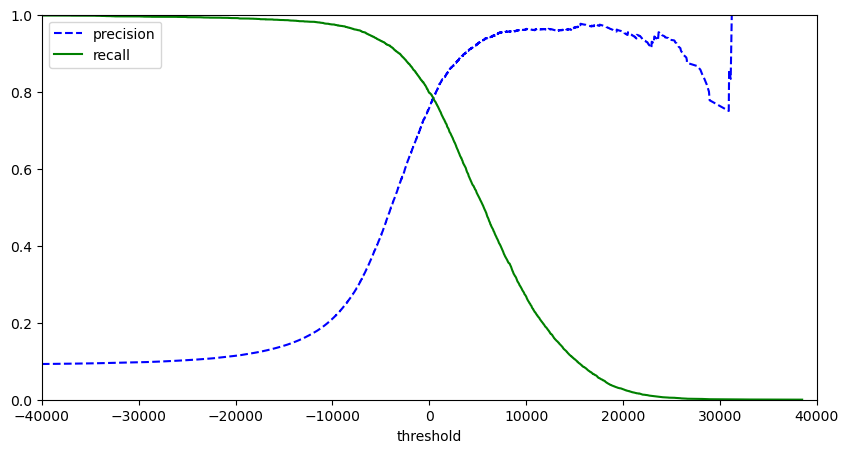

In [74]:
def plot_pr_threshold(precisions, recalls, thresholds):
    plt.figure(figsize = (10,5))
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'recall')
    plt.xlabel('threshold')
    plt.xlim(-40000, 40000)
    plt.ylim(0,1)
    plt.legend()
    plt.show()

plot_pr_threshold(precisions, recalls, thresholds)

In [46]:
len(precisions[])

60001